In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### データ読み込み

In [2]:
df_cps1 = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')
df_cps3 = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls3.dta')
df_nsw = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')

### データセット作成

In [3]:
treat_label = {0: 'untreat', 1: 'treat'}

In [4]:
X_columns = ['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']
y_column = 're78'
z_column = 'treat'

#### CPS1+NSW

In [5]:
df_cps1_nsw = pd.concat([df_nsw[df_nsw[z_column] == 1], df_cps1], ignore_index=True)

#### CPS3+NSW

In [6]:
# NSWから介入群を抽出してCPS1と連結
df_cps1_nsw = pd.concat([df_nsw[df_nsw[z_column] == 1], df_cps1], ignore_index=True)
# NSWから介入群を抽出してCPS3と連結
df_cps3_nsw = pd.concat([df_nsw[df_nsw[z_column] == 1], df_cps3], ignore_index=True)

### 介入群と非介入群の分布を確認

#### NSW

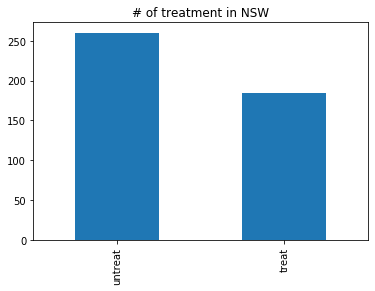

In [7]:
df_nsw[z_column].map(treat_label).value_counts().plot.bar(title='# of treatment in NSW')

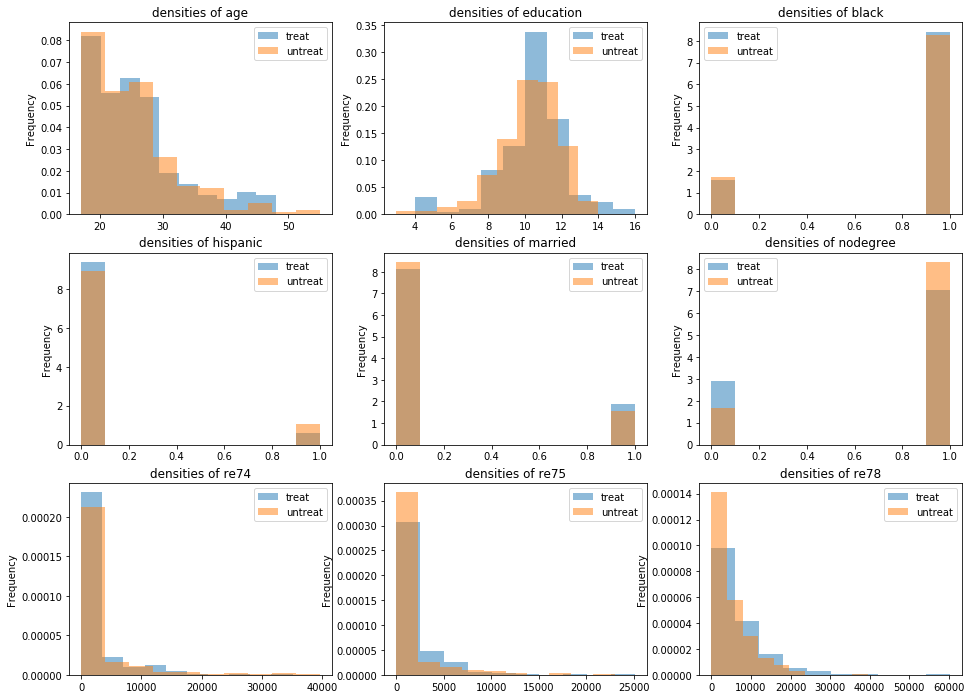

In [8]:
_, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, c in enumerate(X_columns + [y_column]):
    (df_nsw[c].groupby(df_nsw[z_column].map(treat_label))
     .plot.hist(density=True, alpha=0.5, title=f'densities of {c}', legend=True, ax=ax[i // 3, i % 3]))

#### CPS1+NSW

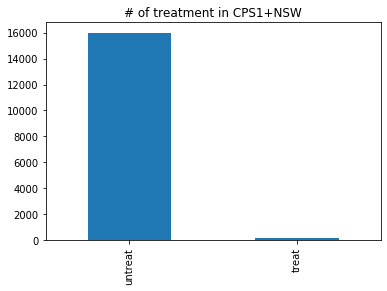

In [9]:
df_cps1_nsw[z_column].map(treat_label).value_counts().plot.bar(title='# of treatment in CPS1+NSW')

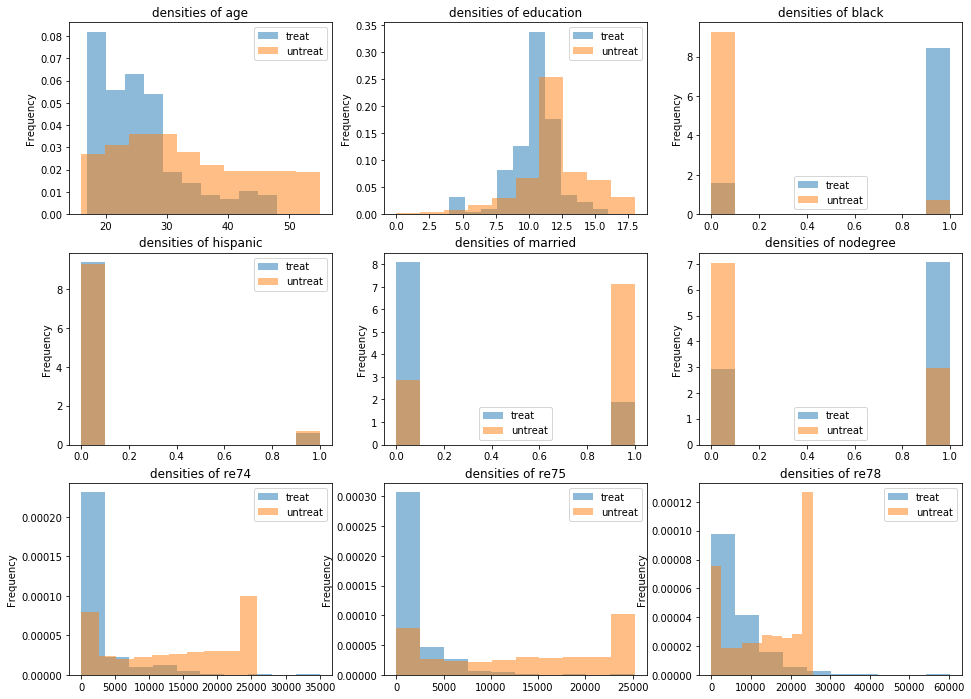

In [10]:
_, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, c in enumerate(X_columns + [y_column]):
    (df_cps1_nsw[c].groupby(df_cps1_nsw[z_column].map(treat_label))
     .plot.hist(density=True, alpha=0.5, title=f'densities of {c}', legend=True, ax=ax[i // 3, i % 3]))

#### CPS3+NSW

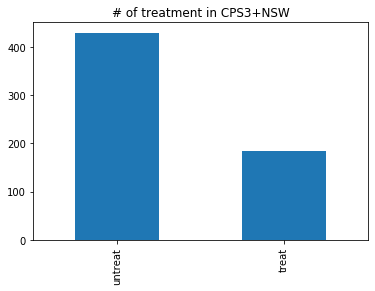

In [11]:
df_cps3_nsw[z_column].map(treat_label).value_counts().plot.bar(title='# of treatment in CPS3+NSW')

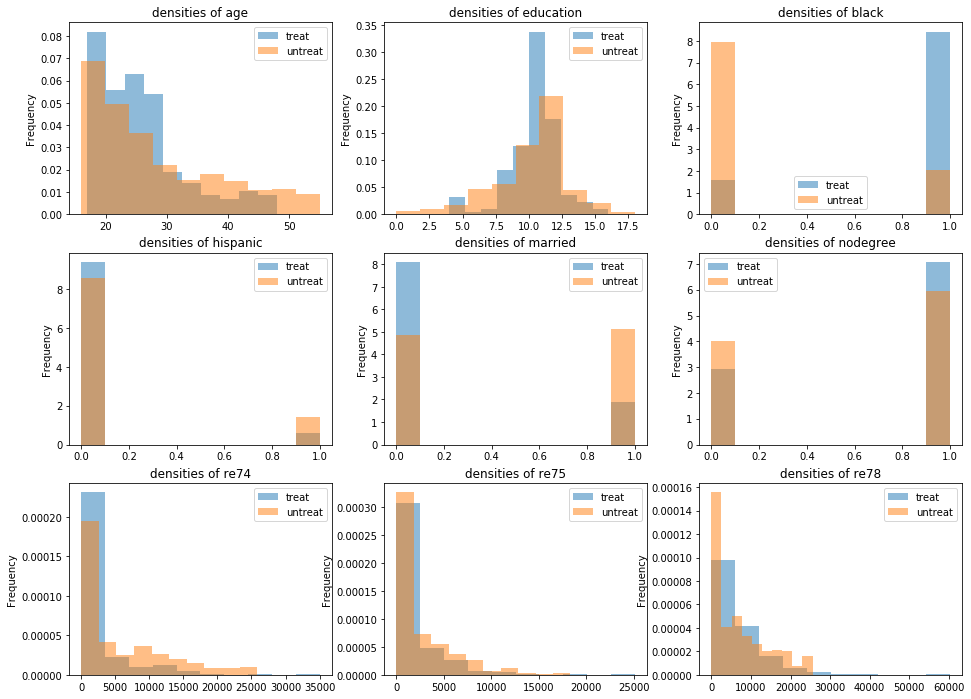

In [12]:
_, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, c in enumerate(X_columns + [y_column]):
    (df_cps3_nsw[c].groupby(df_cps3_nsw[z_column].map(treat_label))
     .plot.hist(density=True, alpha=0.5, title=f'densities of {c}', legend=True, ax=ax[i // 3, i % 3]))

### 回帰分析

In [13]:
import statsmodels.api as sm

#### NSW

In [14]:
results = sm.OLS(df_nsw[y_column], sm.add_constant(df_nsw[[z_column] + X_columns])).fit()
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,785.0614,3374.969,0.233,0.816,-5848.211,7418.334
treat,1676.3426,638.682,2.625,0.009,421.056,2931.629
age,55.3167,45.284,1.222,0.223,-33.686,144.319
education,395.7343,227.415,1.740,0.083,-51.234,842.703
black,-2159.5222,1169.036,-1.847,0.065,-4457.183,138.139
hispanic,164.0327,1549.457,0.106,0.916,-2881.320,3209.386
married,-138.7253,879.728,-0.158,0.875,-1867.771,1590.321
nodegree,-70.6806,1004.387,-0.070,0.944,-2044.736,1903.374
re74,0.0821,0.077,1.061,0.289,-0.070,0.234
re75,0.0528,0.135,0.389,0.697,-0.214,0.319


#### CPS1+NSW

In [15]:
results = sm.OLS(df_cps1_nsw[y_column], sm.add_constant(df_cps1_nsw[[z_column] + X_columns])).fit()
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,5735.7312,445.176,12.884,0.000,4863.138,6608.325
treat,699.1317,547.636,1.277,0.202,-374.296,1772.559
age,-101.8551,5.881,-17.320,0.000,-113.382,-90.328
education,160.1864,28.594,5.602,0.000,104.139,216.234
black,-836.9473,212.826,-3.933,0.000,-1254.109,-419.786
hispanic,-218.3184,218.663,-0.998,0.318,-646.923,210.286
married,73.0758,142.409,0.513,0.608,-206.061,352.212
nodegree,372.2376,177.590,2.096,0.036,24.141,720.334
re74,0.2895,0.012,23.953,0.000,0.266,0.313
re75,0.4707,0.012,38.697,0.000,0.447,0.495


#### CPS3+NSW

In [16]:
results = sm.OLS(df_cps3_nsw[y_column], sm.add_constant(df_cps3_nsw[[z_column] + X_columns])).fit()
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,66.5145,2436.746,0.027,0.978,-4719.009,4852.038
treat,1548.2438,781.279,1.982,0.048,13.890,3082.598
age,12.9776,32.489,0.399,0.690,-50.827,76.783
education,403.9412,158.906,2.542,0.011,91.865,716.017
black,-1240.6441,768.764,-1.614,0.107,-2750.420,269.132
hispanic,498.8968,941.943,0.530,0.597,-1350.984,2348.777
married,406.6208,695.472,0.585,0.559,-959.217,1772.458
nodegree,259.8174,847.442,0.307,0.759,-1404.474,1924.108
re74,0.2964,0.058,5.086,0.000,0.182,0.411
re75,0.2315,0.105,2.213,0.027,0.026,0.437


### 傾向スコアの推定

#### CPS1+NSW

In [17]:
ps_model = sm.Logit(df_cps1_nsw[z_column], sm.add_constant(df_cps1_nsw[X_columns])).fit()
ps_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.031035
         Iterations 12


,coef,std err,z,P>|z|,[0.025,0.975]
const,-5.6050,0.780,-7.187,0.000,-7.133,-4.076
age,-0.0038,0.010,-0.386,0.700,-0.023,0.015
education,0.0346,0.047,0.737,0.461,-0.057,0.127
black,4.2068,0.258,16.315,0.000,3.701,4.712
hispanic,1.7936,0.391,4.589,0.000,1.027,2.560
married,-0.9899,0.235,-4.219,0.000,-1.450,-0.530
nodegree,1.0355,0.264,3.923,0.000,0.518,1.553
re74,-2.925e-05,2.71e-05,-1.078,0.281,-8.25e-05,2.4e-05
re75,-0.0002,3.59e-05,-5.897,0.000,-0.000,-0.000


In [18]:
df_cps1_nsw['ps'] = 1 / (1 + np.exp(-ps_model.fittedvalues))

treat
treat      AxesSubplot(0.125,0.125;0.775x0.755)
untreat    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ps, dtype: object

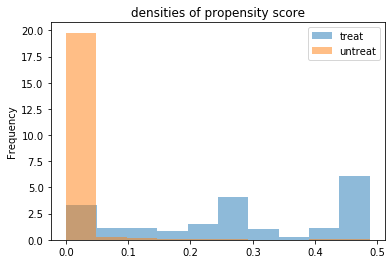

In [19]:
(df_cps1_nsw.groupby(df_cps1_nsw[z_column].map(treat_label))['ps']
 .plot.hist(density=True, alpha=0.5, title=f'densities of propensity score', legend=True))

In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_cps1_nsw[z_column], df_cps1_nsw['ps'])

0.9708918648513447

#### CPS3+NSW

In [21]:
ps_model = sm.Logit(df_cps3_nsw[z_column], sm.add_constant(df_cps3_nsw[X_columns])).fit()
ps_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-4.7286,1.017,-4.649,0.000,-6.722,-2.735
age,0.0158,0.014,1.162,0.245,-0.011,0.042
education,0.1613,0.065,2.477,0.013,0.034,0.289
black,3.0654,0.287,10.698,0.000,2.504,3.627
hispanic,0.9836,0.426,2.311,0.021,0.149,1.818
married,-0.8321,0.290,-2.866,0.004,-1.401,-0.263
nodegree,0.7073,0.338,2.095,0.036,0.045,1.369
re74,-7.178e-05,2.87e-05,-2.497,0.013,-0.000,-1.54e-05
re75,5.345e-05,4.63e-05,1.153,0.249,-3.74e-05,0.000


In [22]:
df_cps3_nsw['ps'] = 1 / (1 + np.exp(-ps_model.fittedvalues))

treat
treat      AxesSubplot(0.125,0.125;0.775x0.755)
untreat    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ps, dtype: object

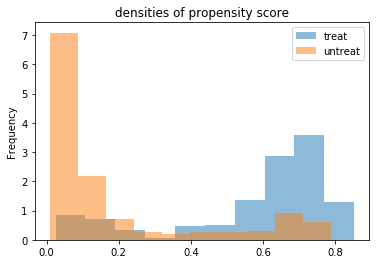

In [23]:
(df_cps3_nsw.groupby(df_cps3_nsw[z_column].map(treat_label))['ps']
 .plot.hist(density=True, alpha=0.5, title=f'densities of propensity score', legend=True))

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_cps3_nsw[z_column], df_cps3_nsw['ps'])

0.8742266742266742

### ATTの推定

#### CPS1+NSW

##### マッチング

In [25]:
from sklearn.neighbors import NearestNeighbors
def pairs_generator(s0: pd.Series, s1: pd.Series, threshold: np.float) -> pd.DataFrame:
    """
    K近傍法を使ってペアを作る再帰ジェネレータ。
    
    Parameters
    ----------
    s0, s1 : pd.Series
    threshold : np.float
        ペアを作る距離の閾値。最近傍点でも閾値を超えた場合はペアとならない。
    
    Returns
    -------
    pairs : pd.DataFrame
        s0のサンプルと、最も近いs1のサンプルで作られたペアのインデックス。
        列lがs0のインデックス、列rがs1のインデックスとなる。
    
    Notes
    -----
    複数のペアに同じサンプルが使われることはない。
    
    Examples
    --------
    s0 = df[df[z_column] == 0]['ps']
    s1 = df[df[z_column] == 1]['ps']
    threshold = df['ps'].std() * 0.1
    pairs = pd.concat(pairs_generator(s1, s0, threshold), ignore_index=True)
    """
    neigh_dist, neigh_ind = NearestNeighbors(1).fit(s0.values.reshape(-1, 1)).kneighbors(s1.values.reshape(-1, 1))
    pairs = pd.DataFrame(
        {'d': neigh_dist[:, 0], 'l': s0.iloc[neigh_ind[:, 0]].index},
        index=s1.index,
    ).query(f'd < {threshold}').groupby('l')['d'].idxmin().rename('r').reset_index()
    if len(pairs) > 0:
        yield pairs
        yield from pairs_generator(s0.drop(pairs['l']), s1.drop(pairs['r']), threshold)

In [26]:
s1 = df_cps1_nsw[df_cps1_nsw[z_column] == 1]['ps']
s0 = df_cps1_nsw[df_cps1_nsw[z_column] == 0]['ps']
threshold = df_cps1_nsw['ps'].std() * 0.1
pairs1_cps1_nsw = pd.concat(pairs_generator(s1, s0, threshold), ignore_index=True)
pairs0_cps1_nsw = pd.concat(pairs_generator(s0, s1, threshold), ignore_index=True) # ATEの計算で使う

In [27]:
len(s1), len(s0), threshold, len(pairs1_cps1_nsw), len(pairs0_cps1_nsw)

(185, 15992, 0.005408479869038687, 168, 168)

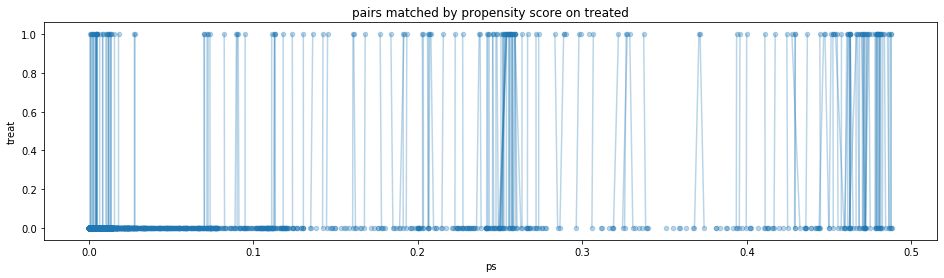

In [28]:
df_cps1_nsw.plot.scatter(x='ps', y=z_column, alpha=0.3, figsize=(16, 4), title='pairs matched by propensity score on treated')
for x in zip(df_cps1_nsw['ps'].iloc[pairs1_cps1_nsw['l']].values, df_cps1_nsw['ps'].iloc[pairs1_cps1_nsw['r']].values):
    plt.plot(x, [1, 0], c='tab:blue', alpha=0.3)

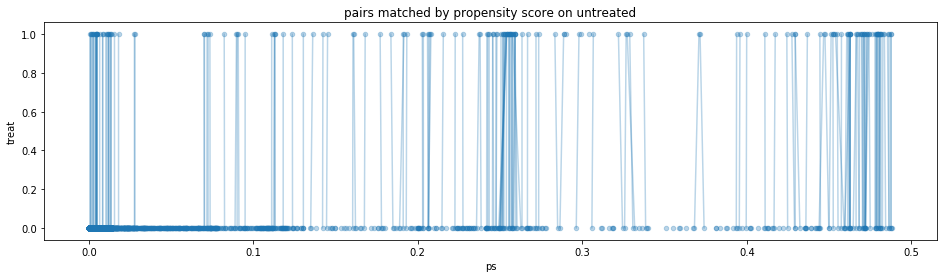

In [29]:
df_cps1_nsw.plot.scatter(x='ps', y=z_column, alpha=0.3, figsize=(16, 4), title='pairs matched by propensity score on untreated')
for x in zip(df_cps1_nsw['ps'].iloc[pairs0_cps1_nsw['l']].values, df_cps1_nsw['ps'].iloc[pairs0_cps1_nsw['r']].values):
    plt.plot(x, [0, 1], c='tab:blue', alpha=0.3)

In [30]:
(pairs1_cps1_nsw['l'].map(df_cps1_nsw[y_column]) - pairs1_cps1_nsw['r'].map(df_cps1_nsw[y_column])).agg(['mean', 'std'])

mean    1929.083008
std     9618.346680
dtype: float64

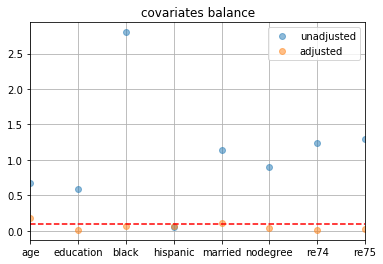

In [31]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps1_nsw.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [pairs1_cps1_nsw['l'].map(df_cps1_nsw[c]).mean() - pairs1_cps1_nsw['r'].map(df_cps1_nsw[c]).mean() for c in X_columns],
}, index=X_columns).abs().divide(df_cps1_nsw[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

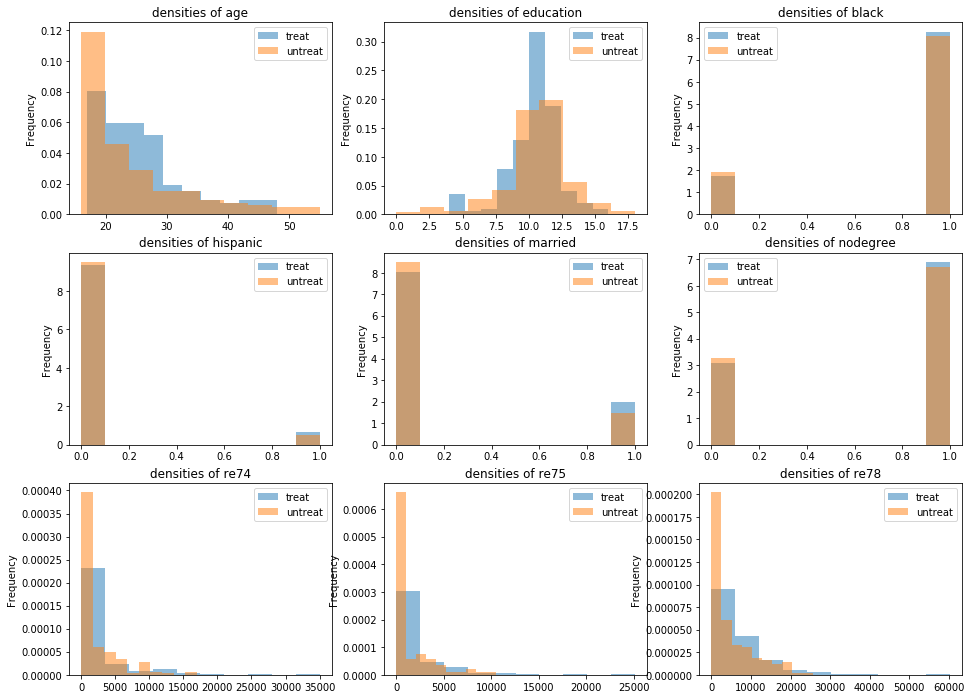

In [32]:
_, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, c in enumerate(X_columns + [y_column]):
    (df_cps1_nsw.loc[pd.concat([pairs1_cps1_nsw['l'], pairs1_cps1_nsw['r']])][c].groupby(df_cps1_nsw[z_column].map(treat_label))
     .plot.hist(density=True, alpha=0.5, title=f'densities of {c}', legend=True, ax=ax[i // 3, i % 3]))

##### IPW

In [33]:
df_cps1_nsw['w'] = df_cps1_nsw[z_column] / df_cps1_nsw['ps'] + (1 - df_cps1_nsw[z_column]) / (1 - df_cps1_nsw['ps'])

In [34]:
att_model = sm.WLS(df_cps1_nsw[y_column], df_cps1_nsw[[z_column]].assign(untreat=1-df_cps1_nsw[z_column]), weights=df_cps1_nsw['w'] * df_cps1_nsw['ps']).fit()
att_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,6349.1435,78.280,81.108,0.000,6195.706,6502.581
untreat,5168.7357,78.453,65.883,0.000,5014.960,5322.512


In [35]:
att_model.params['treat'] - att_model.params['untreat']

1180.4078220960955

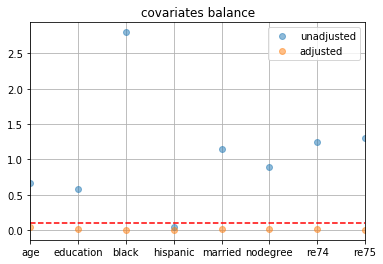

In [36]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps1_nsw.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [np.subtract(*df_cps1_nsw.groupby(z_column).apply(lambda x: np.average(x[c], weights=x['w'] * x['ps']))) for c in X_columns],
}, index=X_columns).abs().divide(df_cps1_nsw[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

##### IPW(コモンサポート)

In [37]:
df_cps1_nsw_cs = df_cps1_nsw[df_cps1_nsw['ps'].between(*df_cps1_nsw.groupby(z_column)['ps'].agg(['min', 'max']).agg({'min': 'max', 'max': 'min'}))].copy()

In [38]:
att_model = sm.WLS(df_cps1_nsw_cs[y_column], df_cps1_nsw_cs[[z_column]].assign(untreat=1-df_cps1_nsw_cs[z_column]), weights=df_cps1_nsw_cs['w'] * df_cps1_nsw_cs['ps']).fit()
att_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,6349.1435,128.406,49.446,0.000,6097.421,6600.866
untreat,5105.2794,129.379,39.460,0.000,4851.650,5358.909


In [39]:
att_model.params['treat'] - att_model.params['untreat']

1243.8640545001808

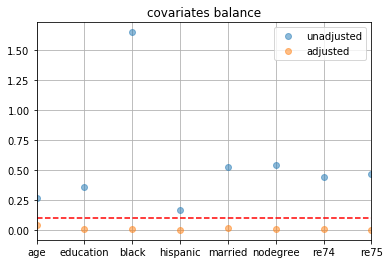

In [40]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps1_nsw_cs.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [np.subtract(*df_cps1_nsw_cs.groupby(z_column).apply(lambda x: np.average(x[c], weights=x['w'] * x['ps']))) for c in X_columns],
}, index=X_columns).abs().divide(df_cps1_nsw_cs[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

#### CPS3+NSW

##### マッチング

In [41]:
s1 = df_cps3_nsw[df_cps3_nsw[z_column] == 1]['ps']
s0 = df_cps3_nsw[df_cps3_nsw[z_column] == 0]['ps']
threshold = df_cps3_nsw['ps'].std() * 0.1
pairs1_cps3_nsw = pd.concat(pairs_generator(s1, s0, threshold), ignore_index=True)
pairs0_cps3_nsw = pd.concat(pairs_generator(s0, s1, threshold), ignore_index=True) # ATEの計算で使う

In [42]:
len(s1), len(s0), threshold, len(pairs1_cps3_nsw), len(pairs0_cps3_nsw)

(185, 429, 0.02903133723196698, 109, 109)

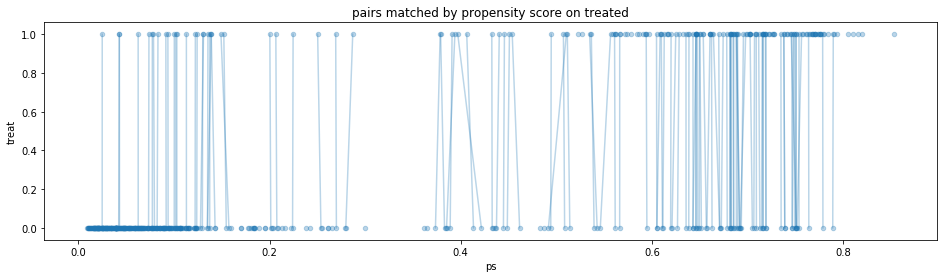

In [43]:
df_cps3_nsw.plot.scatter(x='ps', y=z_column, alpha=0.3, figsize=(16, 4), title='pairs matched by propensity score on treated')
for x in zip(df_cps3_nsw['ps'].iloc[pairs1_cps3_nsw['l']].values, df_cps3_nsw['ps'].iloc[pairs1_cps3_nsw['r']].values):
    plt.plot(x, [1, 0], c='tab:blue', alpha=0.3)

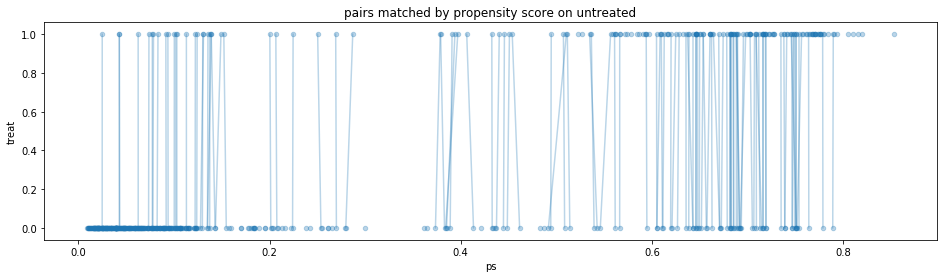

In [44]:
df_cps3_nsw.plot.scatter(x='ps', y=z_column, alpha=0.3, figsize=(16, 4), title='pairs matched by propensity score on untreated')
for x in zip(df_cps3_nsw['ps'].iloc[pairs0_cps3_nsw['l']].values, df_cps3_nsw['ps'].iloc[pairs0_cps3_nsw['r']].values):
    plt.plot(x, [0, 1], c='tab:blue', alpha=0.3)

In [45]:
(pairs1_cps3_nsw['l'].map(df_cps3_nsw[y_column]) - pairs1_cps3_nsw['r'].map(df_cps3_nsw[y_column])).agg(['mean', 'std'])

mean    1463.115845
std     8779.598633
dtype: float64

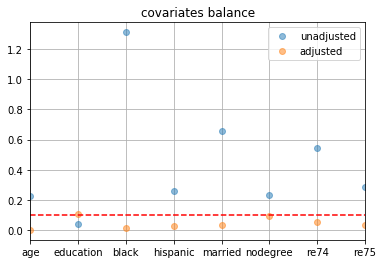

In [46]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps3_nsw.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [pairs1_cps3_nsw['l'].map(df_cps3_nsw[c]).mean() - pairs1_cps3_nsw['r'].map(df_cps3_nsw[c]).mean() for c in X_columns],
}, index=X_columns).abs().divide(df_cps3_nsw[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

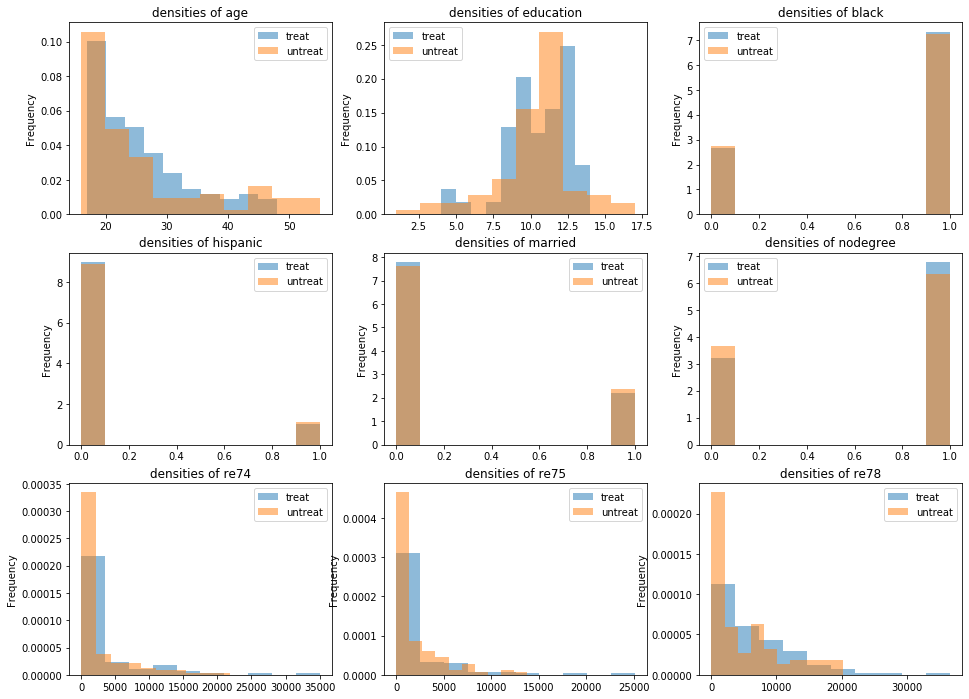

In [47]:
_, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, c in enumerate(X_columns + [y_column]):
    (df_cps3_nsw.loc[pd.concat([pairs1_cps3_nsw['l'], pairs1_cps3_nsw['r']])][c].groupby(df_cps3_nsw[z_column].map(treat_label))
     .plot.hist(density=True, alpha=0.5, title=f'densities of {c}', legend=True, ax=ax[i // 3, i % 3]))

##### IPW

In [48]:
df_cps3_nsw['w'] = df_cps3_nsw[z_column] / df_cps3_nsw['ps'] + (1 - df_cps3_nsw[z_column]) / (1 - df_cps3_nsw['ps'])

In [49]:
att_model = sm.WLS(df_cps3_nsw[y_column], df_cps3_nsw[[z_column]].assign(untreat=1-df_cps3_nsw[z_column]), weights=df_cps3_nsw['w'] * df_cps3_nsw['ps']).fit()
att_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,6349.1435,403.355,15.741,0.000,5557.015,7141.272
untreat,5135.0723,401.194,12.799,0.000,4347.189,5922.956


In [50]:
att_model.params['treat'] - att_model.params['untreat']

1214.0711733143507

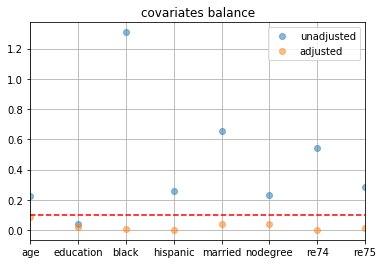

In [51]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps3_nsw.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [np.subtract(*df_cps3_nsw.groupby(z_column).apply(lambda x: np.average(x[c], weights=x['w'] * x['ps']))) for c in X_columns],
}, index=X_columns).abs().divide(df_cps3_nsw[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

##### IPW(コモンサポート)

In [52]:
df_cps3_nsw_cs = df_cps3_nsw[df_cps3_nsw['ps'].between(*df_cps3_nsw.groupby(z_column)['ps'].agg(['min', 'max']).agg({'min': 'max', 'max': 'min'}))].copy()

In [53]:
att_model = sm.WLS(df_cps3_nsw_cs[y_column], df_cps3_nsw_cs[[z_column]].assign(untreat=1-df_cps3_nsw_cs[z_column]), weights=df_cps3_nsw_cs['w'] * df_cps3_nsw_cs['ps']).fit()
att_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,6082.0589,392.684,15.488,0.000,5310.707,6853.411
untreat,5093.1932,383.105,13.294,0.000,4340.655,5845.731


In [54]:
att_model.params['treat'] - att_model.params['untreat']

988.8657151185471

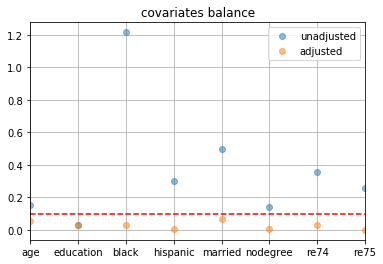

In [55]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps3_nsw_cs.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [np.subtract(*df_cps3_nsw_cs.groupby(z_column).apply(lambda x: np.average(x[c], weights=x['w'] * x['ps']))) for c in X_columns],
}, index=X_columns).abs().divide(df_cps3_nsw_cs[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

### ATEの推定

#### CPS1+NSW

##### マッチング

In [56]:
(pd.concat([pairs1_cps1_nsw['l'], pairs0_cps1_nsw['r']], ignore_index=True).map(df_cps1_nsw[y_column]) - pd.concat([pairs1_cps1_nsw['r'], pairs0_cps1_nsw['l']], ignore_index=True).map(df_cps1_nsw[y_column])).agg(['mean', 'std'])

mean    1836.516968
std     9634.636719
dtype: float64

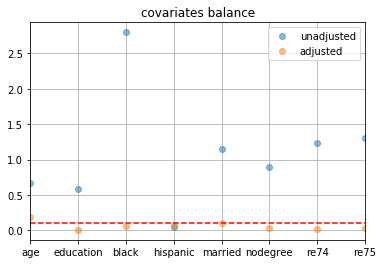

In [57]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps1_nsw.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [pd.concat([pairs1_cps1_nsw['l'], pairs0_cps1_nsw['r']], ignore_index=True).map(df_cps1_nsw[c]).mean() - pd.concat([pairs1_cps1_nsw['r'], pairs0_cps1_nsw['l']], ignore_index=True).map(df_cps1_nsw[c]).mean() for c in X_columns],
}, index=X_columns).abs().divide(df_cps1_nsw[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

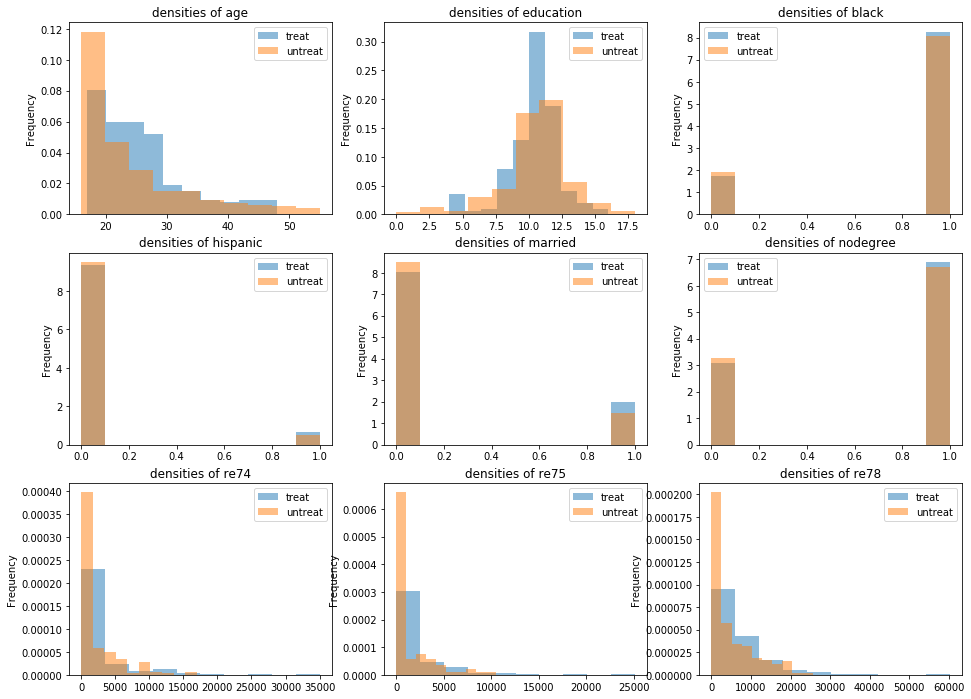

In [58]:
_, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, c in enumerate(X_columns + [y_column]):
    (df_cps1_nsw.loc[pd.concat([pairs1_cps1_nsw['l'], pairs0_cps1_nsw['r'], pairs1_cps1_nsw['r'], pairs0_cps1_nsw['l']])][c].groupby(df_cps1_nsw[z_column].map(treat_label))
     .plot.hist(density=True, alpha=0.5, title=f'densities of {c}', legend=True, ax=ax[i // 3, i % 3]))

##### IPW

In [59]:
ate_model = sm.WLS(df_cps1_nsw[y_column], df_cps1_nsw[[z_column]].assign(untreat=1-df_cps1_nsw[z_column]), weights=df_cps1_nsw['w']).fit()
ate_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,8280.1640,119.479,69.302,0.000,8045.972,8514.356
untreat,1.474e+04,86.022,171.311,0.000,1.46e+04,1.49e+04


In [60]:
ate_model.params['treat'] - ate_model.params['untreat']

-6456.300804768925

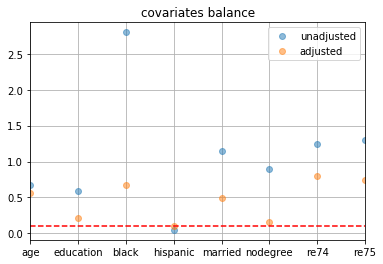

In [61]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps1_nsw.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [np.subtract(*df_cps1_nsw.groupby(z_column).apply(lambda x: np.average(x[c], weights=x['w']))) for c in X_columns],
}, index=X_columns).abs().divide(df_cps1_nsw[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

##### IPW(コモンサポート)

In [62]:
ate_model = sm.WLS(df_cps1_nsw_cs[y_column], df_cps1_nsw_cs[[z_column]].assign(untreat=1-df_cps1_nsw_cs[z_column]), weights=df_cps1_nsw_cs['w']).fit()
ate_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,8280.1640,125.473,65.991,0.000,8034.191,8526.138
untreat,7734.8490,148.849,51.964,0.000,7443.050,8026.648


In [63]:
ate_model.params['treat'] - ate_model.params['untreat']

545.3149727568589

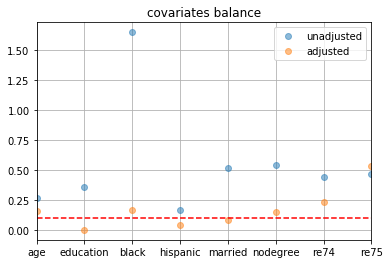

In [64]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps1_nsw_cs.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [np.subtract(*df_cps1_nsw_cs.groupby(z_column).apply(lambda x: np.average(x[c], weights=x['w']))) for c in X_columns],
}, index=X_columns).abs().divide(df_cps1_nsw_cs[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

#### CPS3+NSW

##### マッチング

In [65]:
(pd.concat([pairs1_cps3_nsw['l'], pairs0_cps3_nsw['r']], ignore_index=True).map(df_cps3_nsw[y_column]) - pd.concat([pairs1_cps3_nsw['r'], pairs0_cps3_nsw['l']], ignore_index=True).map(df_cps3_nsw[y_column])).agg(['mean', 'std'])

mean    1486.608276
std     8629.639648
dtype: float64

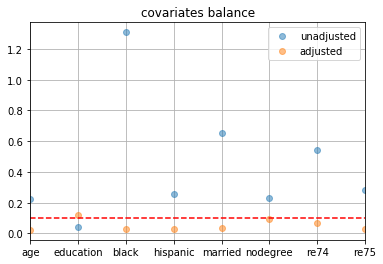

In [66]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps3_nsw.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [pd.concat([pairs1_cps3_nsw['l'], pairs0_cps3_nsw['r']], ignore_index=True).map(df_cps3_nsw[c]).mean() - pd.concat([pairs1_cps3_nsw['r'], pairs0_cps3_nsw['l']], ignore_index=True).map(df_cps3_nsw[c]).mean() for c in X_columns],
}, index=X_columns).abs().divide(df_cps3_nsw[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

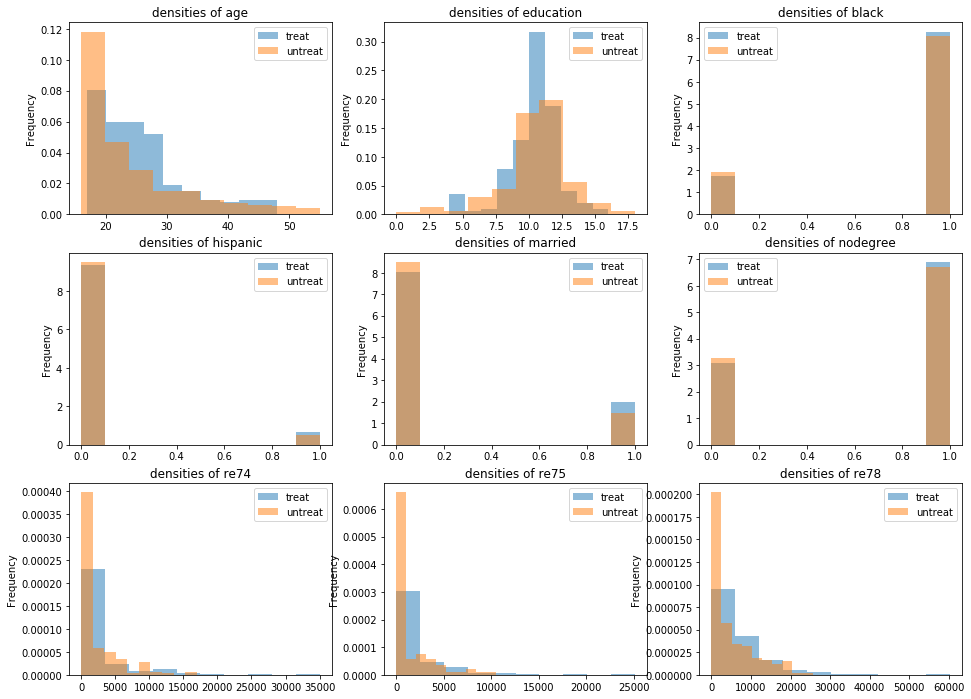

In [67]:
_, ax = plt.subplots(3, 3, figsize=(16, 12))
for i, c in enumerate(X_columns + [y_column]):
    (df_cps1_nsw.loc[pd.concat([pairs1_cps1_nsw['l'], pairs0_cps1_nsw['r'], pairs1_cps1_nsw['r'], pairs0_cps1_nsw['l']])][c].groupby(df_cps1_nsw[z_column].map(treat_label))
     .plot.hist(density=True, alpha=0.5, title=f'densities of {c}', legend=True, ax=ax[i // 3, i % 3]))

##### IPW

In [68]:
ate_model = sm.WLS(df_cps3_nsw[y_column], df_cps3_nsw[[z_column]].assign(untreat=1-df_cps3_nsw[z_column]), weights=df_cps3_nsw['w']).fit()
ate_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,6647.5152,419.214,15.857,0.000,5824.243,7470.787
untreat,6422.8390,397.427,16.161,0.000,5642.353,7203.325


In [69]:
ate_model.params['treat'] - ate_model.params['untreat']

224.6762634665365

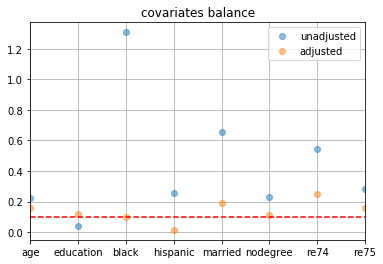

In [70]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps3_nsw.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [np.subtract(*df_cps3_nsw.groupby(z_column).apply(lambda x: np.average(x[c], weights=x['w']))) for c in X_columns],
}, index=X_columns).abs().divide(df_cps3_nsw[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')

##### IPW(コモンサポート)

In [71]:
ate_model = sm.WLS(df_cps3_nsw_cs[y_column], df_cps3_nsw_cs[[z_column]].assign(untreat=1-df_cps3_nsw_cs[z_column]), weights=df_cps3_nsw_cs['w']).fit()
ate_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,6542.5772,404.854,16.160,0.000,5747.318,7337.837
untreat,5741.5036,399.665,14.366,0.000,4956.437,6526.570


In [72]:
ate_model.params['treat'] - ate_model.params['untreat']

801.0736196669177

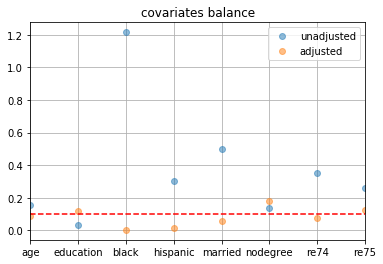

In [73]:
pd.DataFrame({
    'unadjusted': [np.subtract(*df_cps3_nsw_cs.groupby(z_column)[c].mean()) for c in X_columns],
    'adjusted': [np.subtract(*df_cps3_nsw_cs.groupby(z_column).apply(lambda x: np.average(x[c], weights=x['w']))) for c in X_columns],
}, index=X_columns).abs().divide(df_cps3_nsw_cs[X_columns].std(), axis=0).plot(linestyle='', marker='o', alpha=0.5, grid=True, title='covariates balance')
plt.axhline(y=0.1, linestyle='--', c='r')